# Objective

This notebook will describe metrics and baselines before extensive training, we want to get an idea of what the performance of the teacher model should be and what size some of the baseline models are


In [13]:
import json

from pathlib import Path
import pandas as pd
from IPython.display import Image

project_dir = Path.cwd().parent
artifacts_dir = project_dir / "artifacts" / "tbls" / "01_baselines"
artifacts_img_dir = project_dir / "artifacts" / "imgs" / "01_baselines"

In [2]:
def read_val_metrics(path:str, model_name:str = "") -> pd.DataFrame:
    data = json.loads(Path(path).read_text())
    data= {
        f"{model_name}baseline": {
            "accuracy": data["baseline"]["val"]["accuracy"],
            "roc_auc": data["baseline"]["val"]["roc_auc"],
        },
        f"{model_name}tuned": {
            "accuracy": data["tuned"]["val"]["accuracy"],
            "roc_auc": data["tuned"]["val"]["roc_auc"],
        },
    }
    return pd.DataFrame(data)

df_sklearn_report = pd.concat([read_val_metrics(artifacts_dir / "rf" / "rf_artifacts_summary.json", model_name="rf_"),
              read_val_metrics(artifacts_dir / "gbm" / "gbm_artifacts_summary.json", model_name="gbm_"),
              read_val_metrics(artifacts_dir / "logistic_regression" / "artifacts_summary.json", model_name="lr_"),
             ], axis=1).T.reset_index().rename(columns={"index":"model"}).round(3).sort_values(by="roc_auc", ascending=False)

df_sklearn_report

,model,accuracy,roc_auc
3,gbm_tuned,0.901,0.897
2,gbm_baseline,0.904,0.877
5,lr_tuned,0.903,0.877
1,rf_tuned,0.894,0.865
4,lr_baseline,0.895,0.865
0,rf_baseline,0.893,0.857


In [3]:
json_data = json.loads(Path(artifacts_dir / "resnet"/ "resnet_summary.json").read_text())
json_data.keys()

model_keys = ['resnet18']

# 'resnet34', 'resnet50', 'resnet101', 'resnet152'
for model in model_keys:
    print(f"Model: {model}")
    print(f"  Trainable Params: {json_data[model]['params_trainable']}")
    print(f"  Validation Accuracy: {json_data[model]['best_info']['val_acc']}")
    print(f"  Finished Epoch: {json_data[model]['best_info']['epoch']}")

Model: resnet18
  Trainable Params: {'total': 11177538, 'trainable': 1026}
  Validation Accuracy: 0.84375
  Finished Epoch: 11


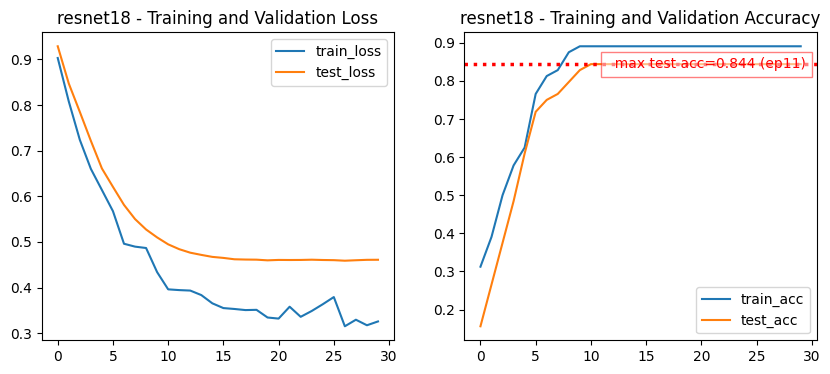

In [17]:
Image(artifacts_img_dir / "resnet" / "resnet18_training_curves.png")